## Diffusion model concept test
### Train a diffusion model on MNIST number data
#### Sample from p(x) to return a value for random numbered input images

In [402]:
# some temporary requirements -- de comment if ever needed for new pyenv
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
#from ipywidgets import FloatProgress
#!pip3 install --upgrade pip
#!pip3 install einops

In [403]:
#-----------------------------#
#  Diffusion modelling MNIST  #
#      Matt Sampson 2022      #
#-----------------------------#
#- import libraries
import matplotlib.pyplot as plt
import random
import imageio
import numpy as np
from argparse import ArgumentParser
from scipy.stats import norm
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.spatial import distance
from scipy.special import rel_entr


from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

import torchvision.transforms as T
from torch.utils.data import Dataset
from torchvision import datasets

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"



Lets start by just loading the the MNIST training and test data as per usual

In [404]:
no_train = False
fashion = False
batch_size = 128
n_epochs = 1
lr = 0.001

Function to show a visualisation of images on a grid

In [405]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

Function to visualise whats being loaded in under the hood

In [406]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

Lets load in the data, since we are using noise reversing diffusion, and noise is distriubted normally, normalise the images to [-1,1].

In [407]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
ds_fn = MNIST 
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)
print(dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )


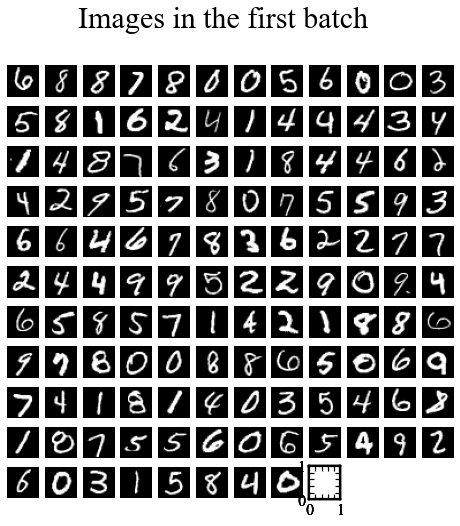

In [408]:
# Optionally, show a batch of regular images
show_first_batch(loader)

Here we use whatever architecture we have available

In [409]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cpu	CPU


Making a diffusion model class

In [410]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

In [411]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [412]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

In [413]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [414]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [415]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [416]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

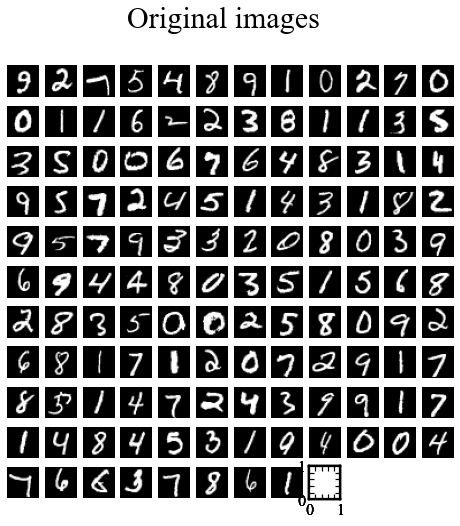

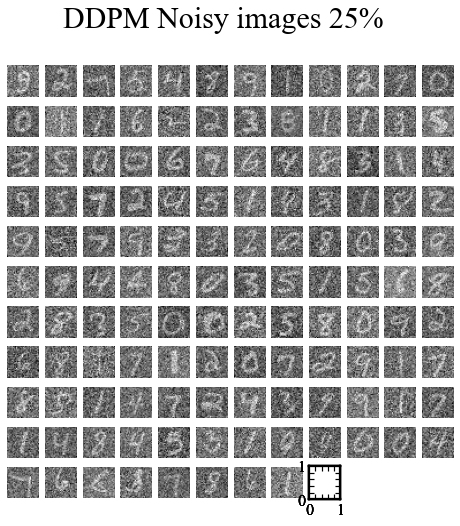

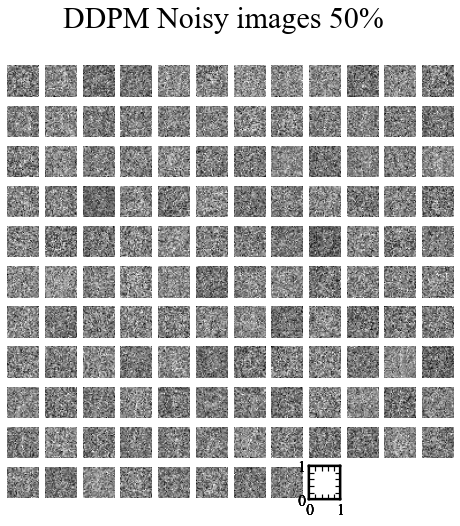

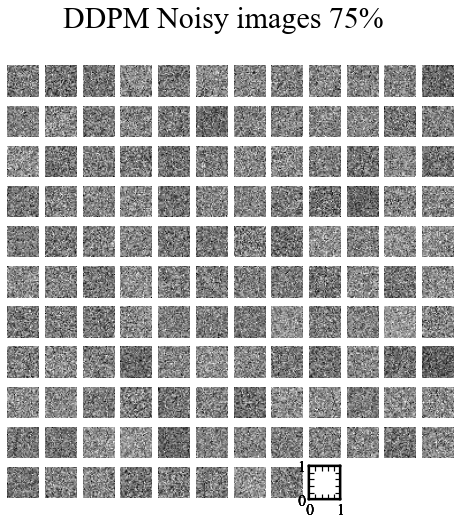

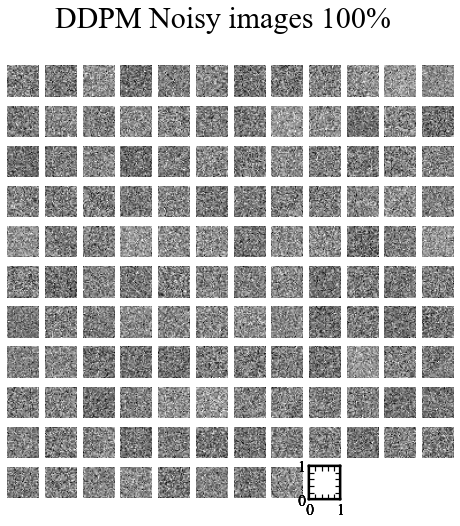

In [417]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, loader, device)

Calculate prob of image by evaluating log likihood of each pixel in image, then summing them up
For a given image, compute the likelyhood that it comes from a gaussian distribution

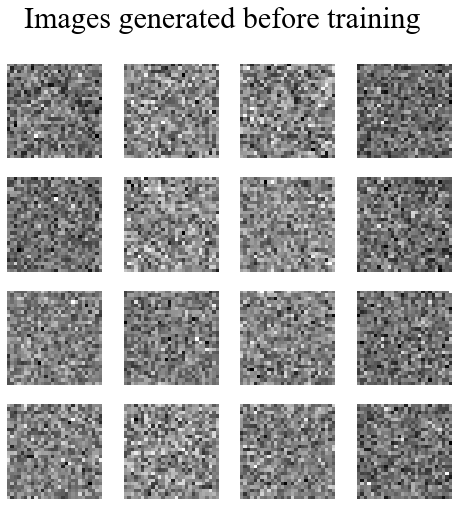

In [418]:
# Optionally, show the denoising (backward) process
generated = generate_new_images(ddpm, gif_name="before_training.gif")
show_images(generated, "Images generated before training")

In [419]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Storing model"

        print(log_string)

In [420]:
#- ML model parameters
no_train = True
fashion = False
batch_size = 128
n_epochs = 20
lr = 0.001

In [421]:
# Training
store_path = "ddpm_mnist.pt"
if not no_train:
    training_loop(ddpm, loader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

In [422]:
# Loading the trained model
best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded: Generating new images")

Model loaded: Generating new images


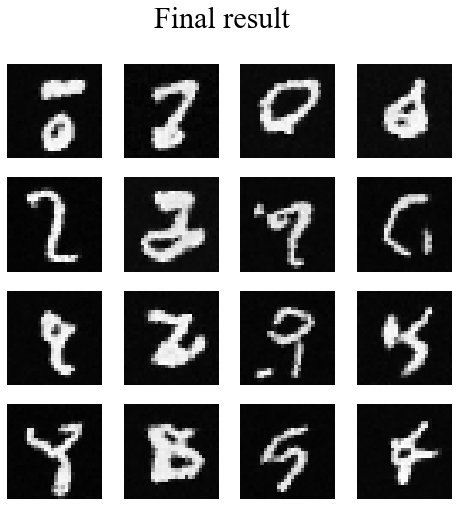

In [423]:
generated = generate_new_images(
        best_model,
        n_samples=16,
        device=device,
        gif_name="number_gen_diffusion_sampson.gif"
    )
show_images(generated, "Final result")

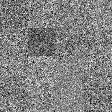

In [424]:
from IPython.display import Image, display
display(Image('number_gen_diffusion_sampson.gif', width=600))

Now lets step outside and try to make a model for binary classificiation based on the Gaussian-ness of the noisy distributions

In [425]:
def measure_gaussian(ddpm, loader, device):
    # measure how Gaussian the nopise distriubtion is
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        # show the final noisy distribution
        for percent in [1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

Now lets test this on our dataset

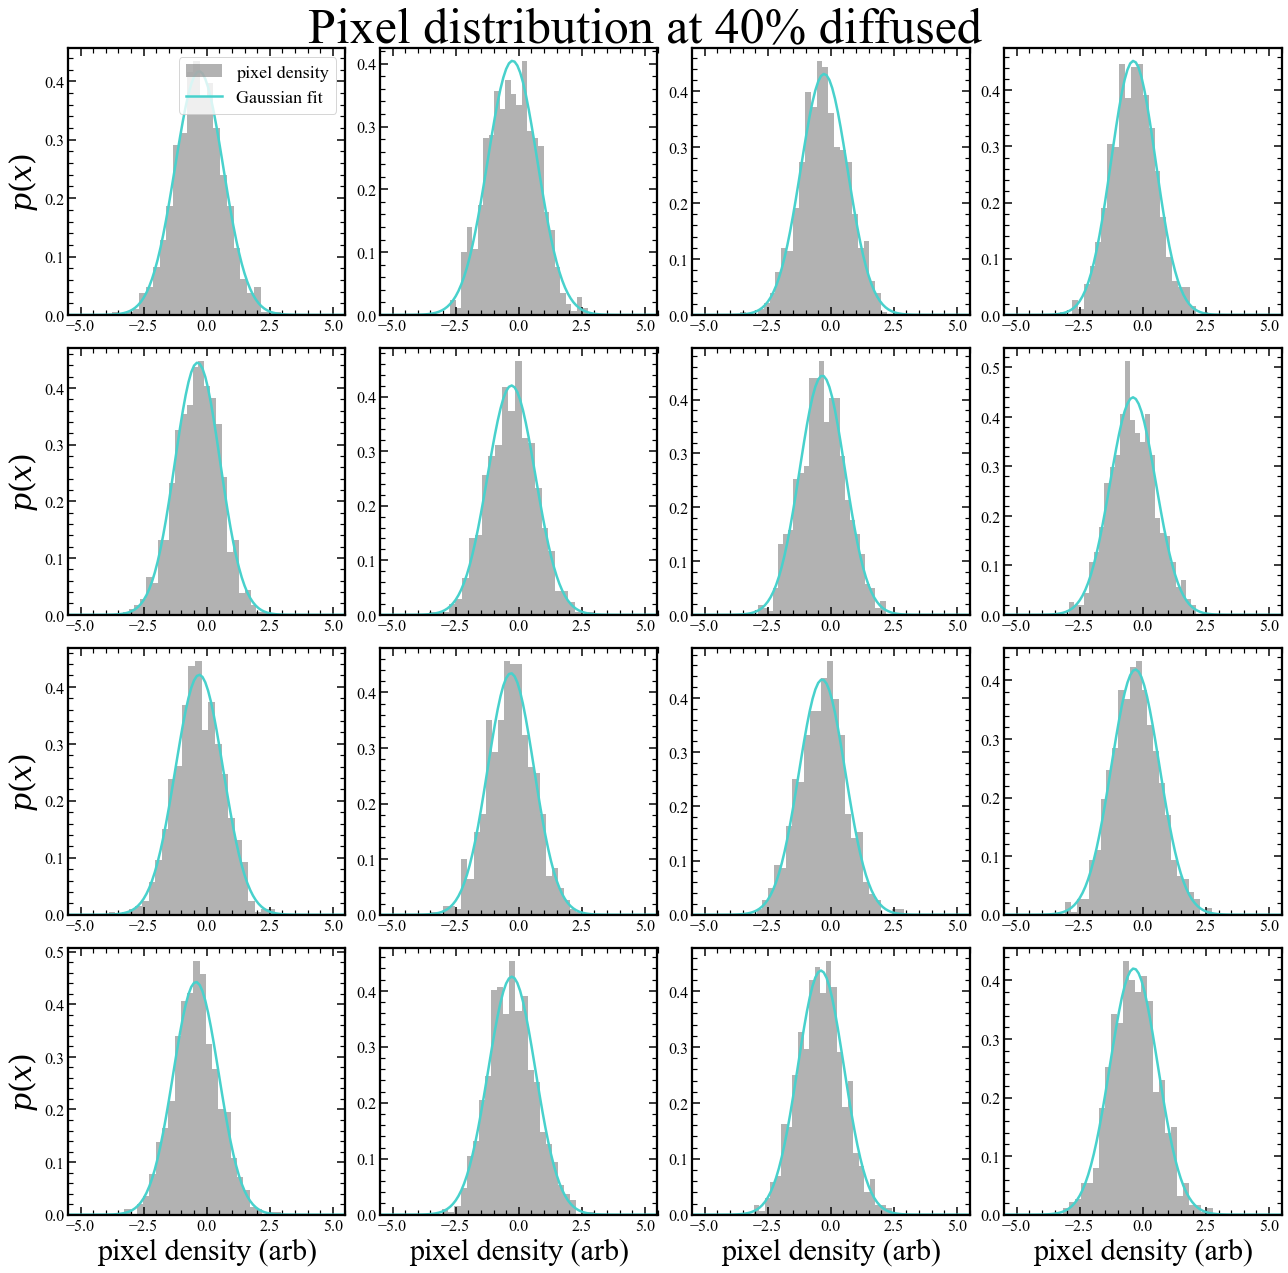

In [426]:
#------------------------------------------------------#
#                     MNIST loader                     #
#------------------------------------------------------#
transform = Compose([
        ToTensor(),
        Lambda(lambda x: (x - 0.5) * 2)])
ds_fn = MNIST 
dataset = ds_fn("./datasets", download=True, 
                train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)
#------------------------------------------------------#

# blur images to percent
percent_step = 0.4

plot_count = 1
# prepping figure 
fig = plt.figure(figsize=(18, 18))

for batch in loader:
        imgs = batch[0]
        imgs = ddpm(imgs.to(device),
                [int(percent_step * ddpm.n_steps) - 1 for _ in range(len(imgs))])
        
        # Now convert tensor dataframe to standard image
        if type(imgs) is torch.Tensor:
                images = imgs.detach().cpu().numpy()
                rows = int(len(images) ** (1 / 2))
                cols = round(len(images) / rows)
        
        # measure distribution of pixel intensity and fit Gaussian
        test_img = ( images[0][0] )
        img_array = np.array(test_img)

        # make a 1-dimensional view of array
        data = img_array.ravel()
        x = np.linspace(0, 1, len(data))        
        
        # Fit a normal distribution to the data:
        mu, std = norm.fit(data)
        
        # Plot row and column numbers
        row_val = col_val = 4

        # Plot the fit
        if (plot_count <= row_val * col_val):
                plt.subplot(row_val,col_val,plot_count)
                plt.hist(data, bins=25, density=True, color = 'gray', 
                        histtype = 'bar',
                        alpha=0.6, linewidth=2, label = 'pixel density')
                plt.xlim([-5.5,5.5])
                
                # make plot labels
                if (plot_count > row_val * col_val - row_val) : plt.xlabel('pixel density (arb)', fontsize = 30)
                if (plot_count % row_val == 1) : plt.ylabel(r'$p(x)$', fontsize = 30)
                
                xmin, xmax = plt.xlim()
                x = np.linspace(xmin, xmax, 100)
                x = np.linspace(xmin, xmax, 100)
                p = norm.pdf(x, mu, std)
                plt.plot(x, p, linewidth=2.5, c = 'mediumturquoise', label = 'Gaussian fit')
                if (plot_count == 1) : plt.legend(fontsize = 18, frameon = True, 
                                                loc = 'upper right')
                
                
        # update plot count
        plot_count += 1
        
# Plot aeasthetics
title = 'Pixel distribution at ' + str( int(percent_step * 100) ) + '% diffused'
plt.subplots_adjust(top=0.92) # adjust suptitle placement
plt.suptitle(title, fontsize = 50)
filename = 'distribution_at_' + str( int(percent_step * 100) ) + '.png'
plt.tight_layout()
plt.savefig(filename, facecolor='white', transparent=False ,dpi = 250)

In [427]:
# measure how Gaussian
percent = np.logspace(-2 , 0 , 40)
error_percentage = np.ones(len(percent))
error = 0
error_single = 0
count = 0
trials = 50
eps = 1e-5
error_1 = []
error_2 = []
error_3 = []

# Fit functions
def Gaussian(x,a,b,c):
    return a * np.exp(-(x - b)**2.0 / (2 * c**2))

def residual(p, x, y):
        return Gaussian(x, *p) - y
                
for i in range(len(percent)):
        print(f'Up to {i+1} / {len(percent)}')
        for batch in loader:
                imgs = batch[0]
                imgs = ddpm(imgs.to(device),
                        [int(percent[i] * ddpm.n_steps) - 1 for _ in range(len(imgs))])
        
                # Now convert tensor dataframe to standard image
                if type(imgs) is torch.Tensor:
                        images = imgs.detach().cpu().numpy()

        
                # measure distribution of pixel intensity and fit Gaussian
                test_img = ( images[0][0] )
                img_array = np.array(test_img)

                # make a 1-dimensional view of array
                data = img_array.ravel()
                
                if (count < trials):
                        n, bins, patches = plt.hist(data, bins=len(data), density=True,label = 'pixel density')
                        plt.close() ; plt.clf()
                        dist = n * ( bins[2] - bins[1] )
                        x = np.linspace(-5.5, 5.5, len(data))     
                        mu, std = norm.fit(data)   
                        x = np.linspace(-5.5, 5.5, len(data))
                        p = norm.pdf(x, 0, 1)
                        p = p / ( np.sum(p) )
                        p = p + eps
                        dist = dist + eps
                        error += ( distance.jensenshannon(p,dist) )**2
                        error_single += ( distance.jensenshannon(p,dist) )**2
                        #error += ( np.sum( (p - dist)**2 ) ) / len(data)
                count += 1
                
                # store error for individual trials
                error_1 = np.append(error_1, error_single)
                error_single = 0
                
                
                # end after collected all trial info
                if (count > trials):
                        break
        
        error_percentage[i] = error / trials
        error = 0
        count = 0
#error_1 = error_1[1 : trials]

Up to 1 / 40
Up to 2 / 40
Up to 3 / 40
Up to 4 / 40
Up to 5 / 40
Up to 6 / 40
Up to 7 / 40
Up to 8 / 40
Up to 9 / 40
Up to 10 / 40
Up to 11 / 40
Up to 12 / 40
Up to 13 / 40
Up to 14 / 40
Up to 15 / 40
Up to 16 / 40
Up to 17 / 40
Up to 18 / 40
Up to 19 / 40
Up to 20 / 40
Up to 21 / 40
Up to 22 / 40
Up to 23 / 40
Up to 24 / 40
Up to 25 / 40
Up to 26 / 40
Up to 27 / 40
Up to 28 / 40
Up to 29 / 40
Up to 30 / 40
Up to 31 / 40
Up to 32 / 40
Up to 33 / 40
Up to 34 / 40
Up to 35 / 40
Up to 36 / 40
Up to 37 / 40
Up to 38 / 40
Up to 39 / 40
Up to 40 / 40


<Figure size 432x288 with 0 Axes>

Test station

Now lets make a rountine to compare how Gaussian our noise is with increased levels of diffusion steps

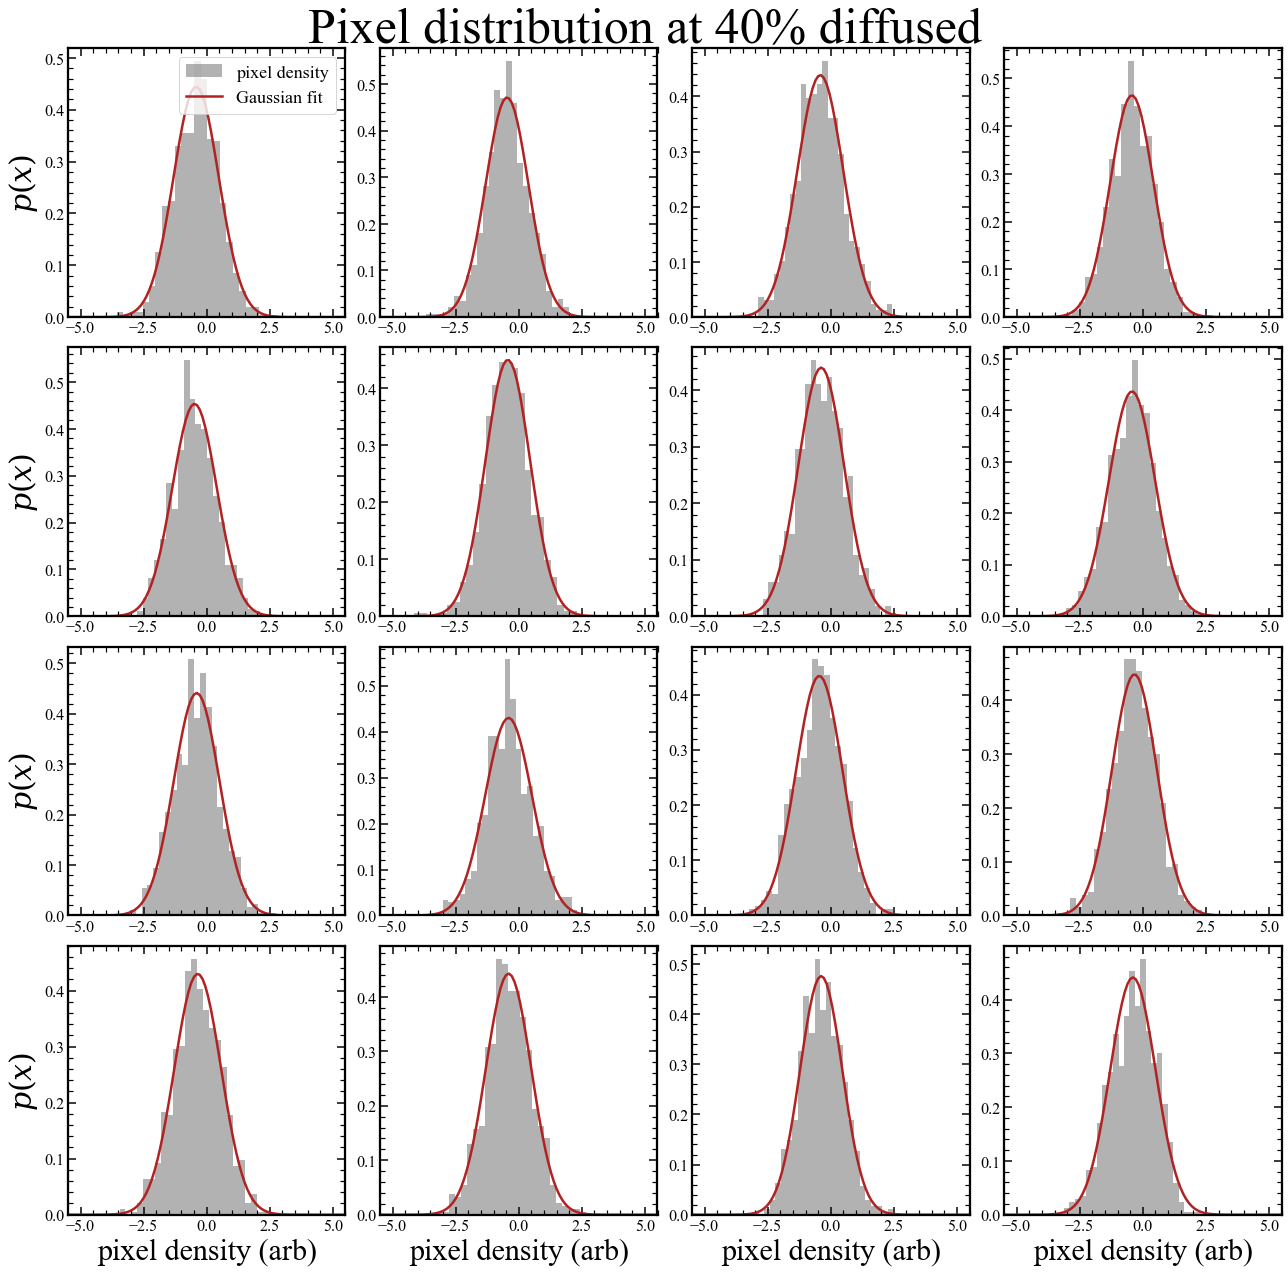

In [428]:
#-------------------------------------------------------------#
#                     galaxy zoo loader                       #
#-------------------------------------------------------------#
im_size = 28 # convert to same size as MNIST
transform  = T.Compose([
        ToTensor(),
        T.Resize(size=(im_size, im_size)),
        Lambda(lambda x: (x - 0.5) * 2),
        T.Grayscale(num_output_channels=1)])
file_name = '/Users/mattsampson/Documents/princeton_research/deblending_diffusion_Sampson_Melchior/datasets/galaxies_sub_sample/'
dataset = datasets.ImageFolder(file_name,
                        transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True)
#-------------------------------------------------------------#

# blur images to percent
percent_step = 0.4

plot_count = 1
# prepping figure 
fig = plt.figure(figsize=(18, 18))

for batch in loader:
        imgs = batch[0]
        imgs = ddpm(imgs.to(device),
                [int(percent_step * ddpm.n_steps) - 1 for _ in range(len(imgs))])
        
        # Now convert tensor dataframe to standard image
        if type(imgs) is torch.Tensor:
                images = imgs.detach().cpu().numpy()
                rows = int(len(images) ** (1 / 2))
                cols = round(len(images) / rows)
        
        # measure distribution of pixel intensity and fit Gaussian
        test_img = ( images[0][0] )
        img_array = np.array(test_img)

        # make a 1-dimensional view of array
        data = img_array.ravel()
        x = np.linspace(0, 1, len(data))        
        
        # Fit a normal distribution to the data:
        mu, std = norm.fit(data)
        
        # Plot row and column numbers
        row_val = col_val = 4

        # Plot the fit
        if (plot_count <= row_val * col_val):
                plt.subplot(row_val,col_val,plot_count)
                plt.hist(data, bins=25, density=True, color = 'gray', histtype = 'bar',
                        alpha=0.6, linewidth=2, label = 'pixel density')
                plt.xlim([-5.5,5.5])
                
                # make plot labels
                if (plot_count > row_val * col_val - row_val) : plt.xlabel('pixel density (arb)', fontsize = 30)
                if (plot_count % row_val == 1) : plt.ylabel(r'$p(x)$', fontsize = 30)
                
                xmin, xmax = plt.xlim()
                x = np.linspace(xmin, xmax, 100)
                x = np.linspace(xmin, xmax, 100)
                p = norm.pdf(x, mu, std)
                plt.plot(x, p, linewidth=2.5, c = 'firebrick', label = 'Gaussian fit')
                if (plot_count == 1) : plt.legend(fontsize = 18, frameon = True, 
                                                loc = 'upper right')
                
                
        # update plot count
        plot_count += 1
        
# Plot aeasthetics
title = 'Pixel distribution at ' + str( int(percent_step * 100) ) + '% diffused'
plt.subplots_adjust(top=0.92) # adjust suptitle placement
plt.suptitle(title, fontsize = 50)
filename = 'NOT_distribution_at_' + str( int(percent_step * 100) ) + '.png'
plt.tight_layout()
plt.savefig(filename, facecolor='white', transparent=False ,dpi = 250)

Now lets try using this same model on new input data

In [429]:
# measure how Gaussian
error_percentage_NOT = np.ones(len(percent))
error = 0
count = 0
for i in range(len(percent)):
        print(f'Up to {i+1} / {len(percent)}')
        for batch in loader:
                imgs = batch[0]
                imgs = ddpm(imgs.to(device),
                        [int(percent[i] * ddpm.n_steps) - 1 for _ in range(len(imgs))])
        
                # Now convert tensor dataframe to standard image
                if type(imgs) is torch.Tensor:
                        images = imgs.detach().cpu().numpy()

        
                # measure distribution of pixel intensity and fit Gaussian
                test_img = ( images[0][0] )
                img_array = np.array(test_img)

                # make a 1-dimensional view of array
                data = img_array.ravel()

                
                if (count < trials):
                        n, bins, patches = plt.hist(data, bins=len(data), density=True,label = 'pixel density')
                        dist = n * ( bins[2] - bins[1] )
                        plt.close() ; plt.clf()
                        x = np.linspace(-5.5, 5.5, len(data))     
                        mu, std = norm.fit(data)   
                        x = np.linspace(-5.5, 5.5, len(data))
                        p = norm.pdf(x, 0, 1)
                        p = p / ( np.sum(p) )
                        p = p + eps
                        dist = dist + eps
                        error += ( distance.jensenshannon(p,dist) )**2
                        error_single += ( distance.jensenshannon(p,dist) )**2
                        #error += np.sum( rel_entr(p, data) )
                        #error += ( np.sum( (p - dist)**2 ) ) / len(data)
                count += 1
                
                # store error for individual trials
                error_2 = np.append(error_2, error_single)
                error_single = 0
                
                # end after collected all trial info
                if (count > trials):
                        break
                
        error_percentage_NOT[i] = error / trials
        error = 0
        count = 0

        

Up to 1 / 40
Up to 2 / 40
Up to 3 / 40
Up to 4 / 40
Up to 5 / 40
Up to 6 / 40
Up to 7 / 40
Up to 8 / 40
Up to 9 / 40
Up to 10 / 40
Up to 11 / 40
Up to 12 / 40
Up to 13 / 40
Up to 14 / 40
Up to 15 / 40
Up to 16 / 40
Up to 17 / 40
Up to 18 / 40
Up to 19 / 40
Up to 20 / 40
Up to 21 / 40
Up to 22 / 40
Up to 23 / 40
Up to 24 / 40
Up to 25 / 40
Up to 26 / 40
Up to 27 / 40
Up to 28 / 40
Up to 29 / 40
Up to 30 / 40
Up to 31 / 40
Up to 32 / 40
Up to 33 / 40
Up to 34 / 40
Up to 35 / 40
Up to 36 / 40
Up to 37 / 40
Up to 38 / 40
Up to 39 / 40
Up to 40 / 40


<Figure size 432x288 with 0 Axes>

Now for the fashion dataset

In [430]:
#---------------------------------------------------------#
#                  fashion data loader                    #
#---------------------------------------------------------#
transform = Compose([
        ToTensor(),
        Lambda(lambda x: (x - 0.5) * 2)])
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"
ds_fn = FashionMNIST
dataset = ds_fn("./datasets", download=True, 
                train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)
print(dataset)
#--------------------------------------------------------#

#----------------------#
# measure how Gaussian #
#----------------------#
error_percentage_fashion = np.ones(len(percent))
error = 0
count = 0
for i in range(len(percent)):
        print(f'Up to {i+1} / {len(percent)}')
        for batch in loader:
                imgs = batch[0]
                imgs = ddpm(imgs.to(device),
                        [int(percent[i] * ddpm.n_steps) - 1 for _ in range(len(imgs))])
        
                # Now convert tensor dataframe to standard image
                if type(imgs) is torch.Tensor:
                        images = imgs.detach().cpu().numpy()

        
                # measure distribution of pixel intensity and fit Gaussian
                test_img = ( images[0][0] )
                img_array = np.array(test_img)

                # make a 1-dimensional view of array
                data = img_array.ravel()

                
                if (count < trials):
                        n, bins, patches = plt.hist(data, bins=len(data), density=True,label = 'pixel density')
                        dist = n * ( bins[2] - bins[1] )
                        plt.close() ; plt.clf()
                        x = np.linspace(-5.5, 5.5, len(data))     
                        mu, std = norm.fit(data)   
                        x = np.linspace(-5.5, 5.5, len(data))
                        p = norm.pdf(x, 0, 1)  # enforce standardised Gaussian
                        p = p / ( np.sum(p) )
                        p = p + eps
                        dist = dist + eps
                        error += ( distance.jensenshannon(p,dist) )**2
                        error_single += ( distance.jensenshannon(p,dist) )**2
                        #error += np.sum( rel_entr(p, data) )
                        #error += ( np.sum( (p - dist)**2 ) ) / len(data)
                count += 1
                
                # store error for individual trials
                error_3 = np.append(error_3, error_single)
                error_single = 0
                
                # end after collected all trial info
                if (count > trials):
                        break
                
        error_percentage_fashion[i] = error / trials
        error = 0
        count = 0

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )
Up to 1 / 40
Up to 2 / 40
Up to 3 / 40
Up to 4 / 40
Up to 5 / 40
Up to 6 / 40
Up to 7 / 40
Up to 8 / 40
Up to 9 / 40
Up to 10 / 40
Up to 11 / 40
Up to 12 / 40
Up to 13 / 40
Up to 14 / 40
Up to 15 / 40
Up to 16 / 40
Up to 17 / 40
Up to 18 / 40
Up to 19 / 40
Up to 20 / 40
Up to 21 / 40
Up to 22 / 40
Up to 23 / 40
Up to 24 / 40
Up to 25 / 40
Up to 26 / 40
Up to 27 / 40
Up to 28 / 40
Up to 29 / 40
Up to 30 / 40
Up to 31 / 40
Up to 32 / 40
Up to 33 / 40
Up to 34 / 40
Up to 35 / 40
Up to 36 / 40
Up to 37 / 40
Up to 38 / 40
Up to 39 / 40
Up to 40 / 40


<Figure size 432x288 with 0 Axes>

Now plot the comparison

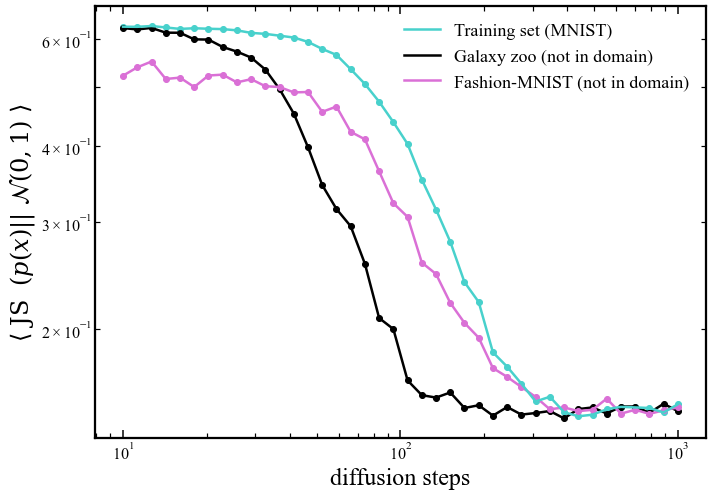

In [431]:
import matplotlib as mpl
# colours
col_MNIST   = 'mediumturquoise'
col_ZOO     = 'black'
col_fashion = 'orchid'
x = percent * n_steps

fig= plt.figure(figsize=(10, 7))

'''
#------------------------------#
#- plot the individual trials -#
for j in range(len(percent)):
    # start value
    start = j
    # skipping every 4th element
    n = trials
    # declaring new list
    new_arr = []  
    # looping over array
    for i in error_1:
        # checking if element is nth pos
        if(start % n == 0):
            if (i != 0.0):
                new_arr.append(i)
        # incrementing counter
        start += 1 
    plt.plot(x, new_arr , color = col_MNIST, lw = 0.5, alpha = 0.4)
    
    
for j in range(len(percent)):
    # start value
    start = j
    # skipping every 4th element
    n = trials
    # declaring new list
    new_arr = []  
    # looping over array
    for i in error_2:
        # checking if element is nth pos
        if(start % n == 0):
            if (i != 0.0):
                new_arr.append(i)
        # incrementing counter
        start += 1 
    plt.plot(x, new_arr , color = col_ZOO, lw = 0.5, alpha = 0.4)
    
    
for j in range(len(percent)):
    # start value
    start = j
    # skipping every 4th element
    n = trials
    # declaring new list
    new_arr = []  
    # looping over array
    for i in error_3:
        # checking if element is nth pos
        if(start % n == 0):
            if (i != 0.0):
                new_arr.append(i)
        # incrementing counter
        start += 1 
    plt.plot(x, new_arr , color = col_fashion, lw = 0.5, alpha = 0.4)
'''


plt.plot(x, error_percentage, label = 'Training set (MNIST)', color = col_MNIST, zorder = 4)
plt.scatter(x, error_percentage, zorder = 2, color = col_MNIST)
plt.plot(x, error_percentage_NOT, label = r'Galaxy zoo (not in domain)', color = col_ZOO, zorder = 2)
plt.scatter(x, error_percentage_NOT, zorder = 2, color = col_ZOO)
plt.plot(x, error_percentage_fashion, label = r'Fashion-MNIST (not in domain)', color = col_fashion, zorder = 2)
plt.scatter(x, error_percentage_fashion, zorder = 2, color = col_fashion)
plt.xlabel('diffusion steps',fontsize = 24)
plt.ylabel(r"$\langle \ \rm{JS}  \ $ $(p(x)  || \ \mathcal{N}(0,1)  \ \rangle $",fontsize = 24)


#- power function by eye fits -#
def power_func(x,a,k):
    # in loglog a is y-int and k is gradient
    y = a * x**k
    return y

# MNIST
#plt.plot(x[0:13],power_func(x[0:13],63,-1.1), c = col_MNIST, 
#        ls = '--', lw = 1.5, label = r'$\frac{log(y)}{log(x)} = -1.1$')

# galaxy zoo
#plt.plot(x[0:28],power_func(x[0:28],2.18,-0.42), c = 'k', 
#        ls = '--', lw = 1.5, label = r'$\frac{log(y)}{log(x)} = -0.42$')

# fashion
#plt.plot(x[0:17],power_func(x[0:17],11.3,-0.75), c = col_fashion, 
#        ls = '--', lw = 1.5, label = r'$\frac{log(y)}{log(x)} = -0.75$')

#- log scaling -#
locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax = plt.gca()
plt.tick_params(axis='x', which='minor')
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
plt.xscale('log')
plt.yscale('log')

#plt.axvspan(650,1100, color = 'gray', alpha = 0.4)
#plt.xlim([10, 00])

plt.legend(frameon = False, fontsize = 18)
plt.tight_layout()
plt.savefig('compare_sets.png',facecolor='white', transparent=False ,dpi = 250)

1 - Enforce that the Gaussian is N(0,1), easy to do just set mu, std in code test section to 0,1
2 - Potentially the sequencing shape could match with the evolution of the JS p(x) || N(0,1)